# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score
from torch.optim.lr_scheduler import OneCycleLR
from transformers import AutoTokenizer, AutoModelForSequenceClassification
# From skfin
from sklearn.feature_extraction.text import CountVectorizer

c:\Users\mcgpr\anaconda3\envs\skfin\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Utils

In [3]:
def load_data(include_news=False):
    prices = pd.read_csv('data/sp500_prices.csv')
    prices['date'] = pd.to_datetime(prices['Date'])
    prices = prices.drop(columns=['Date'])
    prices.sort_values(by='date', ascending=True, inplace=True)

    if include_news:
        news = pd.read_csv('data/bis_press_releases.csv')
        news = news.dropna()
        news['date'] = pd.to_datetime(news['date'], format='%d %b %Y')
        news.sort_values(by='date', ascending=True, inplace=True)
        return prices, news
    else:
        return prices

In [4]:
def sequencing(df, companies, sequence_length, include_news=False):
    data = []
    for company in companies:
        if include_news:
            if 'neutral' in df.columns:
                company_data = df[df['Company'] == company][['Close', 'negative', 'neutral', 'positive']].values
            else:
                company_data = df[df['Company'] == company][['Close', 'negative', 'positive']].values
            for i in range(company_data.shape[0]):
                sentiment_values = company_data[i, 1:]
                max_index = np.argmax(sentiment_values)
                binary_sentiment = np.zeros_like(sentiment_values)
                binary_sentiment[max_index] = 1
                company_data[i, 1:] = binary_sentiment
            data.append(company_data)
        else:
            company_data = df[df['Company'] == company][['Close']].values
            data.append(company_data)
    sequenced_data = []
    for d in data:
        if d.shape[0] <= sequence_length:
            print(d.shape)
            continue
        for k in range(d.shape[0] - sequence_length):
            sequence = d[k:k + sequence_length, :]
            sequenced_data.append(sequence)
    sequenced_data = np.array(sequenced_data)
    return sequenced_data

In [5]:
def evaluate_model(model, data_loader, criterion, scalers):
    model.eval()
    predictions = []
    targets = []
    test_loss = 0
    with torch.no_grad():
        for x_batch, y_batch in data_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            loss = criterion(outputs.squeeze(), y_batch)
            test_loss += loss.item()

            preds = outputs.squeeze().cpu().numpy()
            true_values = y_batch.cpu().numpy()
            predictions.extend(preds)
            targets.extend(true_values)
    # Reshape to 2D arrays (scaler expects 2D inputs)
    predictions = np.array(predictions).reshape(-1, 1)
    targets = np.array(targets).reshape(-1, 1)

    scaler = scalers[0]
    # Apply inverse transform
    predictions = scaler.inverse_transform(predictions)
    targets = scaler.inverse_transform(targets)
    return predictions.flatten(), targets.flatten(), test_loss/len(data_loader)

In [6]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data):
        self.data = data
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        x = self.data[idx, :-1, :]
        y = self.data[idx, -1, 0]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

In [7]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, intermediate_dim=64, seed=42):
        super(LSTM, self).__init__()
        self.linear = nn.Linear(input_dim, intermediate_dim)
        self.sigmoid = nn.Sigmoid()
        self.initial_linear = nn.Linear(intermediate_dim, intermediate_dim)
        self.lstm = nn.LSTM(intermediate_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.seed = seed
        self.init_weights()
    
    def forward(self, x):
        # Pass through the initial linear layer
        x = self.linear(x)
        x = self.sigmoid(x)
        x = self.initial_linear(x)
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out
    
    def init_weights(self):
        torch.manual_seed(self.seed)
        nn.init.xavier_uniform_(self.linear.weight.data)
        nn.init.constant_(self.linear.bias.data, 0)
        # Initialize weights for the initial linear layer
        nn.init.xavier_uniform_(self.initial_linear.weight.data)
        nn.init.constant_(self.initial_linear.bias.data, 0)

        # Initialize weights for the LSTM layer
        for name, param in self.lstm.named_parameters():
            if 'weight_ih' in name:
                nn.init.xavier_uniform_(param.data)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param.data)
            elif 'bias' in name:
                nn.init.constant_(param.data, 0)

        # Initialize weights for the fully connected layer
        nn.init.xavier_uniform_(self.fc.weight.data)
        nn.init.constant_(self.fc.bias.data, 0)

In [8]:
class EarlyStopping:
    def __init__(self, patience=10, verbose=True, min_delta=1e-4, save_path="best_model.pth"):
        self.patience = patience
        self.verbose = verbose
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.save_path = save_path

    def __call__(self, val_loss, model):
            if self.best_loss is None or val_loss < self.best_loss - self.min_delta:
                # New best loss found, save the model
                self.best_loss = val_loss
                self.counter = 0
                torch.save(model.state_dict(), self.save_path)
                if self.verbose:
                    print(f"Validation loss improved. Model saved to {self.save_path}")
            else:
                # No improvement, increment counter
                self.counter += 1
                if self.verbose:
                    print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
                if self.counter >= self.patience:
                    self.early_stop = True
                    print("Early stopping triggered.")

# Feeding Price without sentiment as inputs

## Preprocessing

### Data processing

In [9]:
num_companies = 10

In [10]:
prices = load_data()

In [11]:
dates = prices['date'].drop_duplicates().values
split_date = dates[int(0.8 * len(dates))]

train = prices[prices['date'] <= split_date]
val = prices[prices['date'] > split_date]
num_val_dates = len(val['date'].drop_duplicates().values)

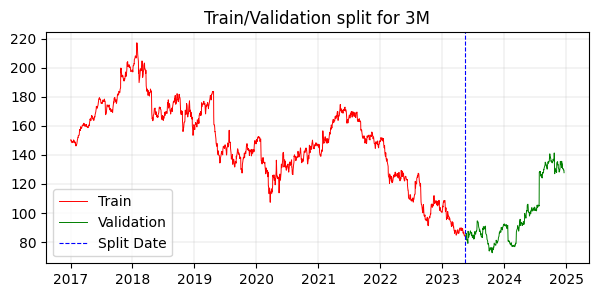

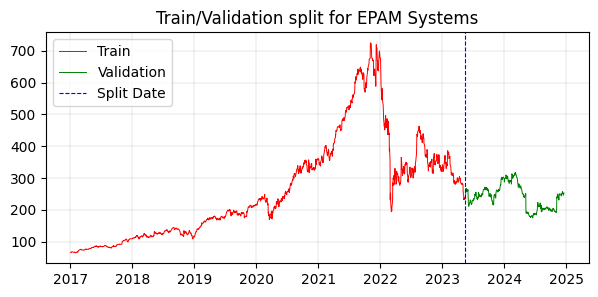

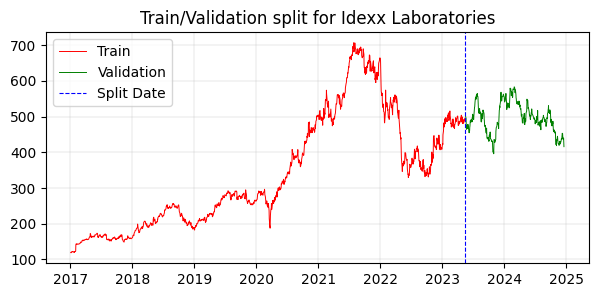

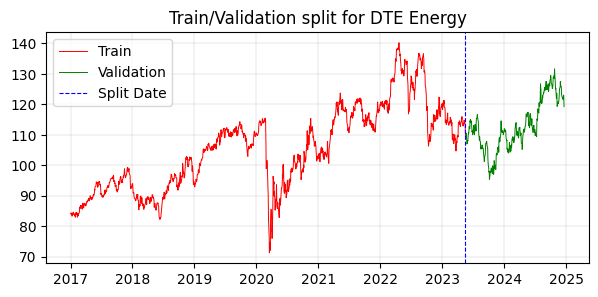

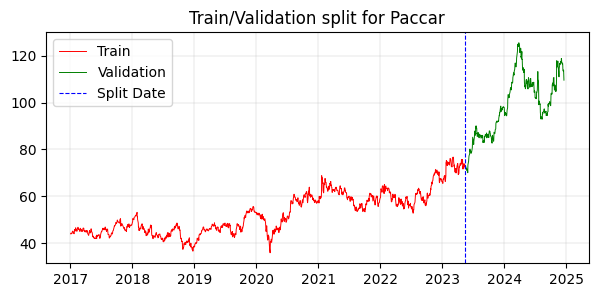

In [12]:
companies = prices['Company'].drop_duplicates().values
for company in companies[:5]:
    train_ex = train[train['Company'] == company]['High'].values
    train_dates = train['date'].drop_duplicates().values
    val_ex = val[val['Company'] == company]['High'].values
    val_dates = val['date'].drop_duplicates().values

    plt.figure(figsize=(7, 3))
    plt.grid(linewidth=0.2)
    plt.plot(train_dates, train_ex, linewidth=0.7, label='Train', c='r')
    plt.plot(val_dates, val_ex, linewidth=0.7, label='Validation', c='g')
    plt.axvline(x=split_date, color='b', linestyle='--', linewidth=0.8, label='Split Date')
    plt.legend()
    plt.title(f'Train/Validation split for {company}')
plt.show()

### Data Augmentation

In [13]:
train_sequence = sequencing(train, companies[:num_companies], 70)
val_sequence = sequencing(val, companies[:num_companies], 50)

print(f'sequenced train data: {train_sequence.shape}')
print(f'sequenced validation data: {val_sequence.shape}')

sequenced train data: (15350, 70, 1)
sequenced validation data: (3500, 50, 1)


## Training

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_data, test_data = train_test_split(train_sequence, test_size=0.2, random_state=42, shuffle=True)
train_data = np.array(train_data)
test_data = np.array(test_data)

num_features = train_data.shape[2]  # Number of features
scalers = [MinMaxScaler(feature_range=(0, 1)) for _ in range(num_features)]

train_data_scaled = np.zeros_like(train_data)
test_data_scaled = np.zeros_like(test_data)

for feature_idx in range(num_features):
    train_feature = train_data[:, :, feature_idx].reshape(-1, 1)  # Shape: (num_samples * seq_len, 1)
    test_feature = test_data[:, :, feature_idx].reshape(-1, 1)
    
    scalers[feature_idx].fit(train_feature)
    
    train_data_scaled[:, :, feature_idx] = scalers[feature_idx].transform(train_feature).reshape(train_data.shape[0], -1)
    test_data_scaled[:, :, feature_idx] = scalers[feature_idx].transform(test_feature).reshape(test_data.shape[0], -1)

train_data = train_data_scaled
test_data = test_data_scaled

train_dataset = TimeSeriesDataset(train_data)
test_dataset = TimeSeriesDataset(test_data)

generator = torch.Generator()
generator.manual_seed(42)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, generator=generator)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, generator=generator)

input_dim = train_data.shape[2]
hidden_dim = 512
num_layers = 1
output_dim = 1

learning_rate=  0.0005
dropout = 0.1
weight_decay = 5e-5

num_epochs = 256

model = LSTM(
    input_dim, 
    hidden_dim, 
    num_layers, 
    output_dim
).to(device)

early_stopping = EarlyStopping(
    patience=32,
    save_path='best_model/withoutsentiment.pth'
)

criterion = nn.MSELoss()

optimizer = torch.optim.Adam(
    model.parameters(), 
    lr=learning_rate, 
    weight_decay=weight_decay
)
steps_per_epoch = len(train_loader)  # Total number of batches in one epoch

scheduler = OneCycleLR(
    optimizer,
    max_lr=learning_rate,
    epochs=num_epochs,
    steps_per_epoch=steps_per_epoch
)

train_loss_rec = []
test_loss_rec = []

print('Model defined, start training ...')
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        # Forward pass
        outputs = model(x_batch)
        loss = criterion(outputs.squeeze(), y_batch)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        train_loss += loss.item()
    
    # Testing loop
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for x_test, y_test in test_loader:
            x_test, y_test = x_test.to(device), y_test.to(device)
            test_outputs = model(x_test)
            loss = criterion(test_outputs.squeeze(), y_test)
            test_loss += loss.item()
    
    # Print metrics
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss/len(train_loader):.8f}, "
          f"Test Loss: {test_loss/len(test_loader):.8f}, LR: {scheduler.get_last_lr()[0]:.6f}")
    train_loss_rec.append(train_loss/len(train_loader))
    test_loss_rec.append(test_loss/len(test_loader))
    
    early_stopping(test_loss, model)
    if early_stopping.early_stop:
        print(f"Early stopping triggered at epoch {epoch+1}.")
        break

Model defined, start training ...
Epoch [1/256], Train Loss: 0.03603452, Test Loss: 0.03247532, LR: 0.000020
Validation loss improved. Model saved to best_model/withoutsentiment.pth
Epoch [2/256], Train Loss: 0.02857084, Test Loss: 0.02497471, LR: 0.000021
Validation loss improved. Model saved to best_model/withoutsentiment.pth
Epoch [3/256], Train Loss: 0.00760060, Test Loss: 0.00043739, LR: 0.000022
Validation loss improved. Model saved to best_model/withoutsentiment.pth
Epoch [4/256], Train Loss: 0.00042417, Test Loss: 0.00034631, LR: 0.000023
Validation loss improved. Model saved to best_model/withoutsentiment.pth
Epoch [5/256], Train Loss: 0.00039063, Test Loss: 0.00036855, LR: 0.000025
EarlyStopping counter: 1 out of 32
Epoch [6/256], Train Loss: 0.00037626, Test Loss: 0.00032882, LR: 0.000027
Validation loss improved. Model saved to best_model/withoutsentiment.pth
Epoch [7/256], Train Loss: 0.00038396, Test Loss: 0.00032513, LR: 0.000030
Validation loss improved. Model saved to 

## Result

### Train/Test Loss through epochs

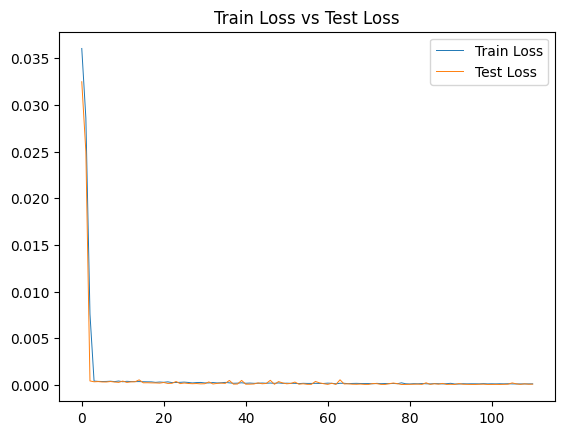

In [15]:
plt.plot(train_loss_rec, linewidth=0.7, label='Train Loss')
plt.plot(test_loss_rec, linewidth=0.7, label='Test Loss')
plt.legend()
plt.title('Train Loss vs Test Loss')
plt.show()

### Reload model

In [16]:
model = LSTM(input_dim, hidden_dim, num_layers, output_dim).to(device)
model.load_state_dict(torch.load('best_model/withoutsentiment.pth'))

C:\Users\mcgpr\AppData\Local\Temp/ipykernel_11892/689271088.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model/withoutsentiment

<All keys matched successfully>

### Test Set

In [17]:
predictions, targets, loss = evaluate_model(model, test_loader, criterion, scalers)
print(f'Loss on test set: {loss:.8f}')
r2 = r2_score(targets, predictions)
print(f"R² Coefficient on Test Set: {r2:.4f}")

Loss on test set: 0.00005836
R² Coefficient on Test Set: 0.9983


### Validation Set

In [18]:
val_data_scaled = np.zeros_like(val_sequence)
for feature_idx in range(num_features):
    feature = val_sequence[:, :, feature_idx].reshape(-1, 1)  # Shape: (num_samples * seq_len, 1)
        
    val_data_scaled[:, :, feature_idx] = scalers[feature_idx].transform(feature).reshape(val_sequence.shape[0], -1)

val_data = val_data_scaled
val_dataset = TimeSeriesDataset(val_data)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

Loss on val set: 0.00006430
R² Coefficient on Validation Set: 0.998312


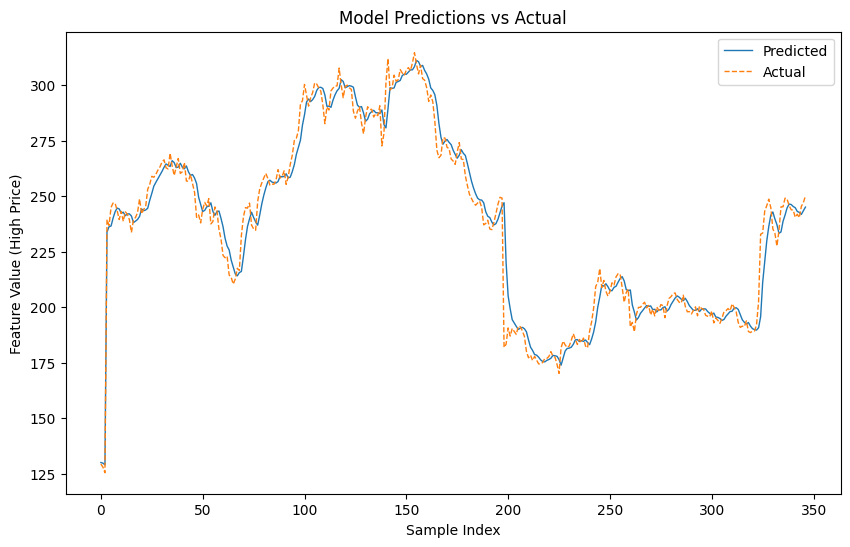

In [19]:
predictions, targets, loss = evaluate_model(model, val_loader, criterion, scalers)
print(f'Loss on val set: {loss:.8f}')
r2 = r2_score(targets, predictions)
print(f"R² Coefficient on Validation Set: {r2:.6f}")

window = 347
initial = 347
plt.figure(figsize=(10, 6))
plt.plot(predictions[initial: initial+window], label="Predicted", linestyle="-", linewidth=1)
plt.plot(targets[initial: initial+window], label="Actual", linestyle="--", linewidth=1)
plt.title("Model Predictions vs Actual")
plt.xlabel("Sample Index")
plt.ylabel("Feature Value (High Price)")
plt.legend()
plt.show()

# Feeding Single Company + FinBERT sentiments

## Preprocessing

### Processing Data

In [20]:
prices, news = load_data(include_news=True)

In [21]:
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

# Move the model to CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Get class labels
class_labels = model.config.id2label
prob_labels = model.config.label2id

# Example input text
text1 = news['content'].values[0]

inputs = tokenizer(text1, return_tensors="pt", truncation=True, padding=True)
inputs = {key: value.to(device) for key, value in inputs.items()}

# Perform inference
with torch.no_grad():  # No gradient calculation needed for predictions
    outputs = model(**inputs)

# Compute probabilities and predicted class
probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
predicted_class = torch.argmax(probs, dim=-1).item()

# Print the results
print("Predicted class:", class_labels[predicted_class])
print("Probabilities:", probs.cpu())  # Move probabilities back to CPU for printing
print('Labels assignation:', prob_labels)

Predicted class: neutral
Probabilities: tensor([[0.1068, 0.2003, 0.6929]])
Labels assignation: {'positive': 0, 'negative': 1, 'neutral': 2}


In [22]:
def sentiment_labelling(df):
    """
    Perform sentiment labelling on the given DataFrame.
    Adds 'negative', 'neutral', and 'positive' columns to the DataFrame.
    Processes the DataFrame to group by date and fill missing values.
    """
    model.to(device)

    df['negative'] = 0.0
    df['neutral'] = 0.0
    df['positive'] = 0.0

    # Initialize the tqdm progress bar
    for index, row in tqdm(df.iterrows(), total=len(df), desc="Processing Sentiment Analysis", dynamic_ncols=True):
        text = row['content']
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
        inputs = {key: value.to(device) for key, value in inputs.items()}  # Move inputs to CUDA
        with torch.no_grad():
            outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1).squeeze().tolist()
        df.at[index, 'positive'] = probs[0]
        df.at[index, 'negative'] = probs[1]
        df.at[index, 'neutral'] = probs[2]

    # Drop unnecessary columns
    if {'url', 'title', 'content'}.issubset(df.columns):
        df = df.drop(columns=['url', 'title', 'content'])

    # Group by date and calculate mean sentiment scores
    df = df.groupby("date").mean().reset_index()

    # Ensure the 'date' column is in datetime format
    df['date'] = pd.to_datetime(df['date'])

    # Create a full date range
    date_range = pd.date_range(start=df["date"].min(), end=df["date"].max())

    # Reindex to include all dates and forward-fill missing values
    df = df.set_index("date").reindex(date_range)
    df = df.fillna(method="ffill").reset_index()
    df.rename(columns={"index": "date"}, inplace=True)

    df = df.sort_values(by="date", ascending=True).reset_index(drop=True)

    return df

In [23]:
news = sentiment_labelling(news)

Processing Sentiment Analysis: 100%|██████████| 6886/6886 [02:43<00:00, 42.16it/s]


In [24]:
news.head()

,date,negative,neutral,positive
0,2017-01-24,0.200346,0.692896,0.106758
1,2017-01-25,0.027849,0.678937,0.293214
2,2017-01-26,0.057628,0.740360,0.202012
3,2017-01-27,0.685202,0.247965,0.066833
4,2017-01-28,0.685202,0.247965,0.066833


In [25]:
merged = pd.merge(prices, news, on='date', how='inner')
dates = merged['date'].drop_duplicates().values
split_date = dates[int(0.8 * len(dates))]

train = merged[merged['date'] <= split_date]
val = merged[merged['date'] > split_date]
num_val_dates = len(val['date'].drop_duplicates().values)

In [26]:
merged.head()

,Open,High,Low,Close,Volume,Company,date,negative,neutral,positive
0,13.960000,14.340000,13.950000,14.240000,16160200,Regions Financial Corporation,2017-01-24,0.200346,0.692896,0.106758
1,1678.000000,1719.479980,1678.000000,1700.000000,45200,"NVR, Inc.",2017-01-24,0.200346,0.692896,0.106758
2,39.623909,40.496979,39.469444,40.449966,1372858,Pentair,2017-01-24,0.200346,0.692896,0.106758
3,84.970001,86.580002,84.959999,86.400002,737800,Wabtec,2017-01-24,0.200346,0.692896,0.106758
4,167.160004,169.750000,167.160004,169.509995,600800,Domino's,2017-01-24,0.200346,0.692896,0.106758


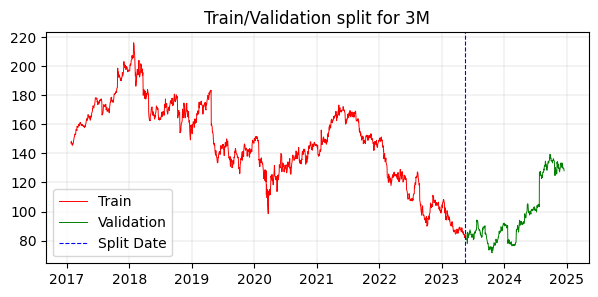

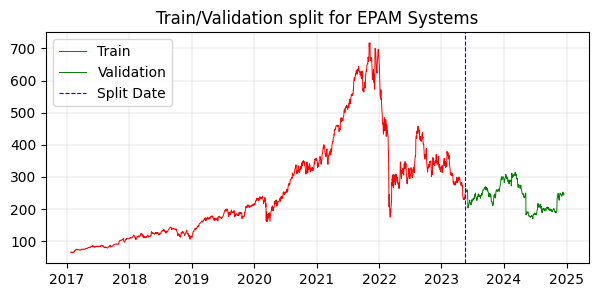

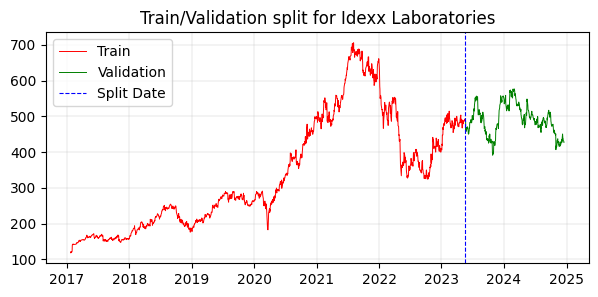

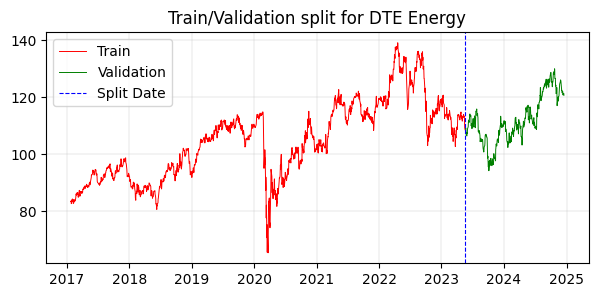

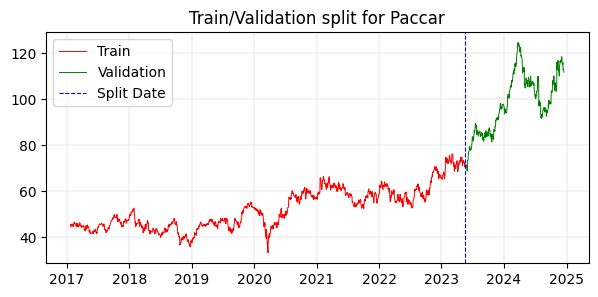

In [27]:
companies = prices['Company'].drop_duplicates().values
for company in companies[:5]:
    train_ex = train[train['Company'] == company]['Close'].values
    train_dates = train['date'].drop_duplicates().values
    val_ex = val[val['Company'] == company]['Close'].values
    val_dates = val['date'].drop_duplicates().values

    plt.figure(figsize=(7, 3))
    plt.grid(linewidth=0.2)
    plt.plot(train_dates, train_ex, linewidth=0.7, label='Train', c='r')
    plt.plot(val_dates, val_ex, linewidth=0.7, label='Validation', c='g')
    plt.axvline(x=split_date, color='b', linestyle='--', linewidth=0.8, label='Split Date')
    plt.legend()
    plt.title(f'Train/Validation split for {company}')
plt.show()

### Data Augmentation

In [28]:
train_sequence = sequencing(train, companies[:num_companies], 70, include_news=True)
val_sequence = sequencing(val, companies[:num_companies], 50, include_news=True)

print(f'sequenced train data: {train_sequence.shape}')
print(f'sequenced validation data: {val_sequence.shape}')

sequenced train data: (15220, 70, 4)
sequenced validation data: (3470, 50, 4)


## Training

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_data, test_data = train_test_split(train_sequence, test_size=0.2, random_state=42, shuffle=True)
train_data = np.array(train_data)
test_data = np.array(test_data)

num_features = train_data.shape[2]  # Number of features
scalers = [MinMaxScaler(feature_range=(0, 1)) for _ in range(num_features)]

train_data_scaled = np.zeros_like(train_data)
test_data_scaled = np.zeros_like(test_data)

for feature_idx in range(num_features):
    train_feature = train_data[:, :, feature_idx].reshape(-1, 1)  # Shape: (num_samples * seq_len, 1)
    test_feature = test_data[:, :, feature_idx].reshape(-1, 1)
    
    scalers[feature_idx].fit(train_feature)
    
    train_data_scaled[:, :, feature_idx] = scalers[feature_idx].transform(train_feature).reshape(train_data.shape[0], -1)
    test_data_scaled[:, :, feature_idx] = scalers[feature_idx].transform(test_feature).reshape(test_data.shape[0], -1)

train_data = train_data_scaled
test_data = test_data_scaled

train_dataset = TimeSeriesDataset(train_data)
test_dataset = TimeSeriesDataset(test_data)

generator = torch.Generator()
generator.manual_seed(42)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, generator=generator)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, generator=generator)

input_dim = train_data.shape[2]
hidden_dim = 512
num_layers = 1
output_dim = 1

learning_rate=  0.0005
dropout = 0.1
weight_decay = 5e-5

num_epochs = 256

model = LSTM(
    input_dim, 
    hidden_dim, 
    num_layers, 
    output_dim
).to(device)

early_stopping = EarlyStopping(
    patience=128,
    save_path='best_model/FinBert.pth'
)

criterion = nn.MSELoss()

optimizer = torch.optim.Adam(
    model.parameters(), 
    lr=learning_rate, 
    weight_decay=weight_decay
)
steps_per_epoch = len(train_loader)  # Total number of batches in one epoch

scheduler = OneCycleLR(
    optimizer,
    max_lr=learning_rate,
    epochs=num_epochs,
    steps_per_epoch=steps_per_epoch
)

train_loss_rec = []
test_loss_rec = []

print('Model defined, start training ...')
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        # Forward pass
        outputs = model(x_batch)
        loss = criterion(outputs.squeeze(), y_batch)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        train_loss += loss.item()
    
    # Testing loop
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for x_test, y_test in test_loader:
            x_test, y_test = x_test.to(device), y_test.to(device)
            test_outputs = model(x_test)
            loss = criterion(test_outputs.squeeze(), y_test)
            test_loss += loss.item()
    
    # Print metrics
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss/len(train_loader):.8f}, "
          f"Test Loss: {test_loss/len(test_loader):.8f}, LR: {scheduler.get_last_lr()[0]:.6f}")
    train_loss_rec.append(train_loss/len(train_loader))
    test_loss_rec.append(test_loss/len(test_loader))
    
    early_stopping(test_loss, model)
    if early_stopping.early_stop:
        print(f"Early stopping triggered at epoch {epoch+1}.")
        break

Model defined, start training ...
Epoch [1/256], Train Loss: 0.03331907, Test Loss: 0.03154059, LR: 0.000020
Validation loss improved. Model saved to best_model/FinBert.pth
Epoch [2/256], Train Loss: 0.02360051, Test Loss: 0.00549415, LR: 0.000021
Validation loss improved. Model saved to best_model/FinBert.pth
Epoch [3/256], Train Loss: 0.00154285, Test Loss: 0.00059421, LR: 0.000022
Validation loss improved. Model saved to best_model/FinBert.pth
Epoch [4/256], Train Loss: 0.00058035, Test Loss: 0.00045058, LR: 0.000023
Validation loss improved. Model saved to best_model/FinBert.pth
Epoch [5/256], Train Loss: 0.00045064, Test Loss: 0.00032582, LR: 0.000025
Validation loss improved. Model saved to best_model/FinBert.pth
Epoch [6/256], Train Loss: 0.00041861, Test Loss: 0.00043302, LR: 0.000027
EarlyStopping counter: 1 out of 128
Epoch [7/256], Train Loss: 0.00043934, Test Loss: 0.00045081, LR: 0.000030
EarlyStopping counter: 2 out of 128
Epoch [8/256], Train Loss: 0.00042650, Test Loss:

## Result

### Train/Test loss through epochs

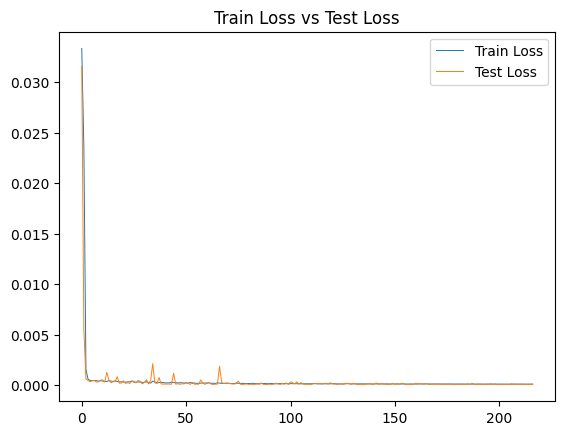

In [30]:
plt.plot(train_loss_rec, linewidth=0.7, label='Train Loss')
plt.plot(test_loss_rec, linewidth=0.7, label='Test Loss')
plt.legend()
plt.title('Train Loss vs Test Loss')
plt.show()

### Reload Model

In [31]:
model = LSTM(input_dim, hidden_dim, num_layers, output_dim).to(device)
model.load_state_dict(torch.load('best_model/FinBert.pth'))

C:\Users\mcgpr\AppData\Local\Temp/ipykernel_11892/2839631630.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model/FinBert.pth'))


<All keys matched successfully>

### Test Set

In [32]:
predictions, targets, loss = evaluate_model(model, test_loader, criterion, scalers)
print(f'Loss on test set: {loss:.8f}')
r2 = r2_score(targets, predictions)
print(f"R² Coefficient on Test Set: {r2:.4f}")

Loss on test set: 0.00005296
R² Coefficient on Test Set: 0.9985


### Validation Set

In [33]:
val_data_scaled = np.zeros_like(val_sequence)
for feature_idx in range(num_features):
    feature = val_sequence[:, :, feature_idx].reshape(-1, 1)  # Shape: (num_samples * seq_len, 1)
        
    val_data_scaled[:, :, feature_idx] = scalers[feature_idx].transform(feature).reshape(val_sequence.shape[0], -1)

val_data = val_data_scaled
val_dataset = TimeSeriesDataset(val_data)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

Loss on val set: 0.00006315
R² Coefficient on Validation Set: 0.998330


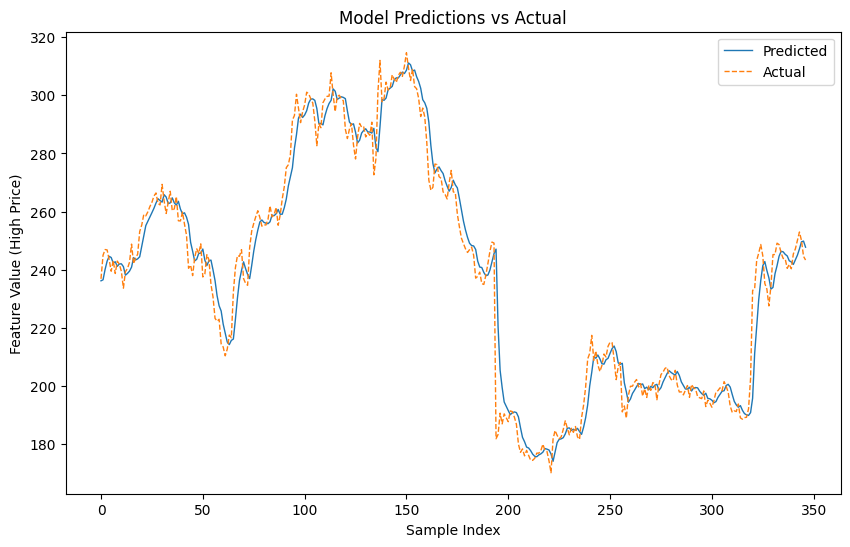

In [34]:
predictions, targets, loss = evaluate_model(model, val_loader, criterion, scalers)
print(f'Loss on val set: {loss:.8f}')
r2 = r2_score(targets, predictions)
print(f"R² Coefficient on Validation Set: {r2:.6f}")

window = 347
initial = 347
plt.figure(figsize=(10, 6))
plt.plot(predictions[initial: initial+window], label="Predicted", linestyle="-", linewidth=1)
plt.plot(targets[initial: initial+window], label="Actual", linestyle="--", linewidth=1)
plt.title("Model Predictions vs Actual")
plt.xlabel("Sample Index")
plt.ylabel("Feature Value (High Price)")
plt.legend()
plt.show()

# Feeding Single Company + sentiments

## Preprocessing

### Data Processing

In [35]:
prices, news = load_data(include_news=True)

In [36]:
from datasets import load_loughran_mcdonald_dictionary

In [37]:
lm = load_loughran_mcdonald_dictionary()

INFO:datasets:Loading from cache file: data\Loughran-McDonald_MasterDictionary_1993-2023.csv


In [38]:
def sentiment_labelling(df, lm, column):
    """
    Perform sentiment labelling on the given DataFrame.
    Adds 'negative', 'neutral', and 'positive' columns to the DataFrame.
    Processes the DataFrame to group by date and fill missing values.
    """
    # Initialize sentiment columns
    # Extract the text column
    X = df[column]
    
    # Define sentiment functions
    funcs = {
        "negative": lambda x: x.Negative > 0,
        "positive": lambda x: x.Positive > 0,
        "all": lambda x: x.Word.notna(),
    }

    # Helper function to compute total count for a specific sentiment
    def get_total_count(X, lm, func):
        m = CountVectorizer(vocabulary=lm.loc[func].Word.str.lower().values)
        return pd.DataFrame(m.fit_transform(X).toarray(), index=X.index).sum(axis=1)

    # Compute sentiment counts for each sentiment category
    lm_counts = pd.concat({k: get_total_count(X, lm, v) for k, v in funcs.items()}, axis=1)

    sentiment_columns = ["negative", "positive"]
    lm_counts[sentiment_columns] = lm_counts[sentiment_columns].div(lm_counts[sentiment_columns].sum(axis=1), axis=0)

    lm_counts.drop(columns=["all"], inplace=True)

    if 'date' in df.columns:
        lm_counts['date'] = df['date'].values

    lm_counts.reset_index(drop=True, inplace=True)

    if {'url', 'title', 'content'}.issubset(df.columns):
        df = df.drop(columns=['url', 'title', 'content'])

    lm_counts = lm_counts.groupby("date").mean().reset_index()

    lm_counts['date'] = pd.to_datetime(lm_counts['date'])

    date_range = pd.date_range(start=lm_counts["date"].min(), end=lm_counts["date"].max())

    lm_counts = lm_counts.set_index("date").reindex(date_range)
    lm_counts = lm_counts.fillna(method="ffill").reset_index()
    lm_counts.rename(columns={"index": "date"}, inplace=True)

    lm_counts = lm_counts.sort_values(by="date", ascending=True).reset_index(drop=True)

    return lm_counts

In [39]:
news = sentiment_labelling(news, lm, 'content')

In [40]:
news.head()

,date,negative,positive
0,2017-01-24,0.563636,0.436364
1,2017-01-25,0.448746,0.551254
2,2017-01-26,0.482812,0.517188
3,2017-01-27,0.730769,0.269231
4,2017-01-28,0.730769,0.269231


In [41]:
merged = pd.merge(prices, news, on='date', how='inner')
dates = merged['date'].drop_duplicates().values
split_date = dates[int(0.8 * len(dates))]

train = merged[merged['date'] <= split_date]
val = merged[merged['date'] > split_date]
num_val_dates = len(val['date'].drop_duplicates().values)

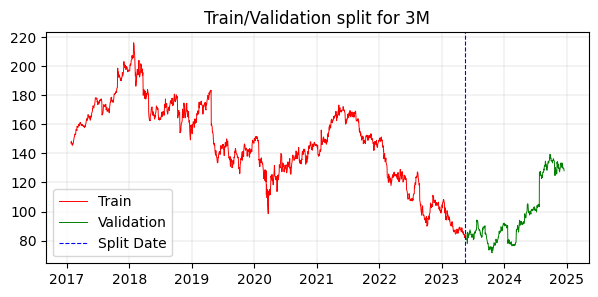

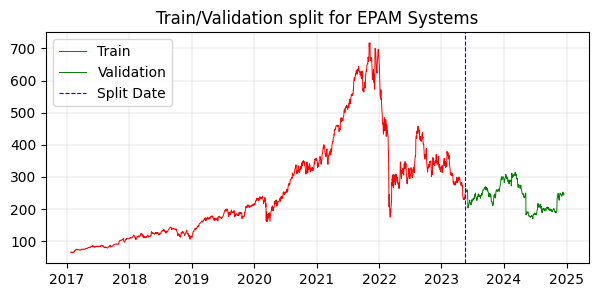

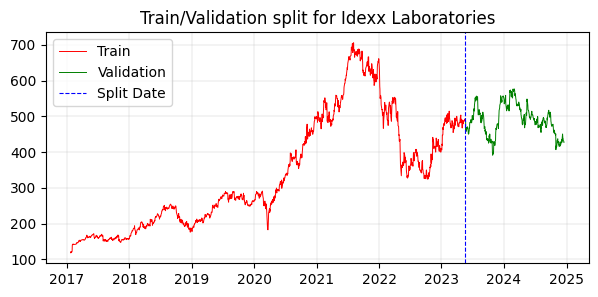

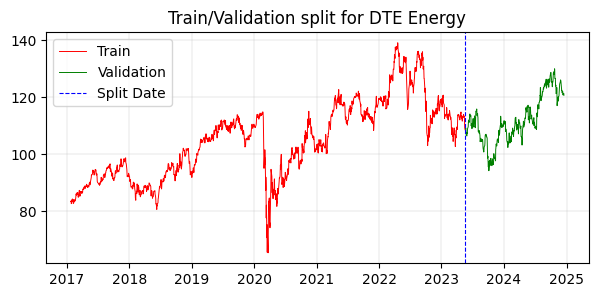

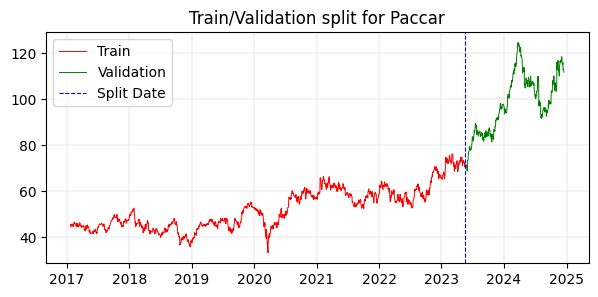

In [42]:
companies = prices['Company'].drop_duplicates().values
for company in companies[:5]:
    train_ex = train[train['Company'] == company]['Close'].values
    train_dates = train['date'].drop_duplicates().values
    val_ex = val[val['Company'] == company]['Close'].values
    val_dates = val['date'].drop_duplicates().values

    plt.figure(figsize=(7, 3))
    plt.grid(linewidth=0.2)
    plt.plot(train_dates, train_ex, linewidth=0.7, label='Train', c='r')
    plt.plot(val_dates, val_ex, linewidth=0.7, label='Validation', c='g')
    plt.axvline(x=split_date, color='b', linestyle='--', linewidth=0.8, label='Split Date')
    plt.legend()
    plt.title(f'Train/Validation split for {company}')
plt.show()

In [43]:
merged.head()

,Open,High,Low,Close,Volume,Company,date,negative,positive
0,13.960000,14.340000,13.950000,14.240000,16160200,Regions Financial Corporation,2017-01-24,0.563636,0.436364
1,1678.000000,1719.479980,1678.000000,1700.000000,45200,"NVR, Inc.",2017-01-24,0.563636,0.436364
2,39.623909,40.496979,39.469444,40.449966,1372858,Pentair,2017-01-24,0.563636,0.436364
3,84.970001,86.580002,84.959999,86.400002,737800,Wabtec,2017-01-24,0.563636,0.436364
4,167.160004,169.750000,167.160004,169.509995,600800,Domino's,2017-01-24,0.563636,0.436364


### Data Augmentation

In [44]:
train_sequence = sequencing(train, companies[:num_companies], 70, include_news=True)
val_sequence = sequencing(val, companies[:num_companies], 50, include_news=True)

print(f'sequenced train data: {train_sequence.shape}')
print(f'sequenced validation data: {val_sequence.shape}')

sequenced train data: (15220, 70, 3)
sequenced validation data: (3470, 50, 3)


## Training

In [45]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_data, test_data = train_test_split(train_sequence, test_size=0.2, random_state=42, shuffle=True)
train_data = np.array(train_data)
test_data = np.array(test_data)

num_features = train_data.shape[2]  # Number of features
scalers = [MinMaxScaler(feature_range=(0, 1)) for _ in range(num_features)]

train_data_scaled = np.zeros_like(train_data)
test_data_scaled = np.zeros_like(test_data)

for feature_idx in range(num_features):
    train_feature = train_data[:, :, feature_idx].reshape(-1, 1)  # Shape: (num_samples * seq_len, 1)
    test_feature = test_data[:, :, feature_idx].reshape(-1, 1)
    
    scalers[feature_idx].fit(train_feature)
    
    train_data_scaled[:, :, feature_idx] = scalers[feature_idx].transform(train_feature).reshape(train_data.shape[0], -1)
    test_data_scaled[:, :, feature_idx] = scalers[feature_idx].transform(test_feature).reshape(test_data.shape[0], -1)

train_data = train_data_scaled
test_data = test_data_scaled

train_dataset = TimeSeriesDataset(train_data)
test_dataset = TimeSeriesDataset(test_data)

generator = torch.Generator()
generator.manual_seed(42)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, generator=generator)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, generator=generator)

input_dim = train_data.shape[2]
hidden_dim = 512
num_layers = 1
output_dim = 1

learning_rate=  0.0005
dropout = 0.1
weight_decay = 5e-5

num_epochs = 256

model = LSTM(
    input_dim, 
    hidden_dim, 
    num_layers, 
    output_dim
).to(device)

early_stopping = EarlyStopping(
    patience=128,
    save_path='best_model/lough_macdo.pth'
)

criterion = nn.MSELoss()

optimizer = torch.optim.Adam(
    model.parameters(), 
    lr=learning_rate, 
    weight_decay=weight_decay
)
steps_per_epoch = len(train_loader)  # Total number of batches in one epoch

scheduler = OneCycleLR(
    optimizer,
    max_lr=learning_rate,
    epochs=num_epochs,
    steps_per_epoch=steps_per_epoch
)

train_loss_rec = []
test_loss_rec = []

print('Model defined, start training ...')
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        # Forward pass
        outputs = model(x_batch)
        loss = criterion(outputs.squeeze(), y_batch)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        train_loss += loss.item()
    
    # Testing loop
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for x_test, y_test in test_loader:
            x_test, y_test = x_test.to(device), y_test.to(device)
            test_outputs = model(x_test)
            loss = criterion(test_outputs.squeeze(), y_test)
            test_loss += loss.item()
    
    # Print metrics
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss/len(train_loader):.8f}, "
          f"Test Loss: {test_loss/len(test_loader):.8f}, LR: {scheduler.get_last_lr()[0]:.6f}")
    train_loss_rec.append(train_loss/len(train_loader))
    test_loss_rec.append(test_loss/len(test_loader))
    
    early_stopping(test_loss, model)
    if early_stopping.early_stop:
        print(f"Early stopping triggered at epoch {epoch+1}.")
        break

Model defined, start training ...
Epoch [1/256], Train Loss: 0.03797069, Test Loss: 0.03428401, LR: 0.000020
Validation loss improved. Model saved to best_model/lough_macdo.pth
Epoch [2/256], Train Loss: 0.03131553, Test Loss: 0.03022084, LR: 0.000021
Validation loss improved. Model saved to best_model/lough_macdo.pth
Epoch [3/256], Train Loss: 0.01962593, Test Loss: 0.00139621, LR: 0.000022
Validation loss improved. Model saved to best_model/lough_macdo.pth
Epoch [4/256], Train Loss: 0.00085205, Test Loss: 0.00041709, LR: 0.000023
Validation loss improved. Model saved to best_model/lough_macdo.pth
Epoch [5/256], Train Loss: 0.00051419, Test Loss: 0.00041279, LR: 0.000025
Validation loss improved. Model saved to best_model/lough_macdo.pth
Epoch [6/256], Train Loss: 0.00048894, Test Loss: 0.00041583, LR: 0.000027
EarlyStopping counter: 1 out of 128
Epoch [7/256], Train Loss: 0.00048037, Test Loss: 0.00048256, LR: 0.000030
EarlyStopping counter: 2 out of 128
Epoch [8/256], Train Loss: 0.

## Result

### Train/Test Loss through epochs

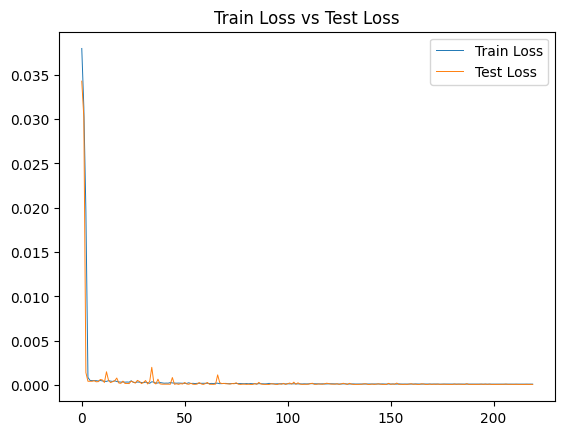

In [46]:
plt.plot(train_loss_rec, linewidth=0.7, label='Train Loss')
plt.plot(test_loss_rec, linewidth=0.7, label='Test Loss')
plt.legend()
plt.title('Train Loss vs Test Loss')
plt.show()

### Reload

In [47]:
model = LSTM(input_dim, hidden_dim, num_layers, output_dim).to(device)
model.load_state_dict(torch.load('best_model/lough_macdo.pth'))

C:\Users\mcgpr\AppData\Local\Temp/ipykernel_11892/2950336300.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model/lough_macdo.pth

<All keys matched successfully>

### Test Set

In [48]:
predictions, targets, loss = evaluate_model(model, test_loader, criterion, scalers)
print(f'Loss on test set: {loss:.8f}')
r2 = r2_score(targets, predictions)
print(f"R² Coefficient on Test Set: {r2:.4f}")

Loss on test set: 0.00005595
R² Coefficient on Test Set: 0.9984


### Validation Set

In [49]:
val_data_scaled = np.zeros_like(val_sequence)
for feature_idx in range(num_features):
    feature = val_sequence[:, :, feature_idx].reshape(-1, 1)  # Shape: (num_samples * seq_len, 1)
        
    val_data_scaled[:, :, feature_idx] = scalers[feature_idx].transform(feature).reshape(val_sequence.shape[0], -1)

val_data = val_data_scaled
val_dataset = TimeSeriesDataset(val_data)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

Loss on val set: 0.00006642
R² Coefficient on Validation Set: 0.998242


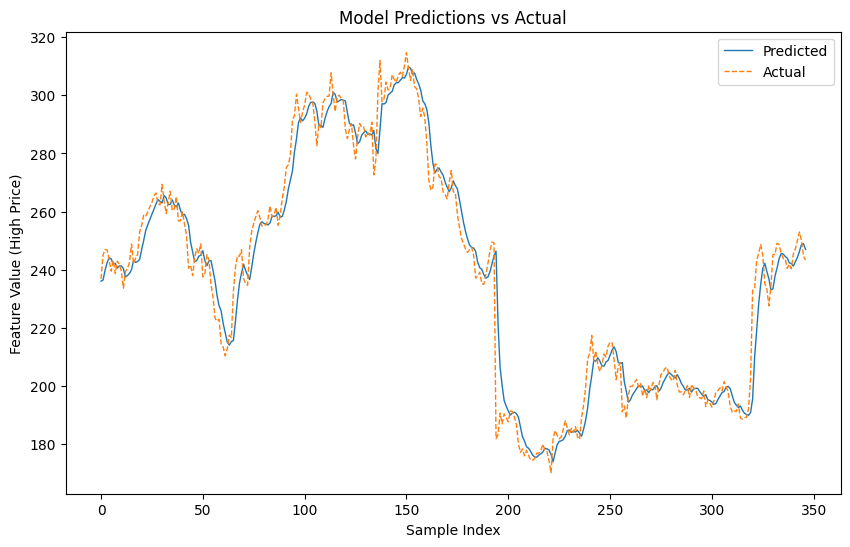

In [50]:
predictions, targets, loss = evaluate_model(model, val_loader, criterion, scalers)
print(f'Loss on val set: {loss:.8f}')
r2 = r2_score(targets, predictions)
print(f"R² Coefficient on Validation Set: {r2:.6f}")

window = 347
initial = 347
plt.figure(figsize=(10, 6))
plt.plot(predictions[initial: initial+window], label="Predicted", linestyle="-", linewidth=1)
plt.plot(targets[initial: initial+window], label="Actual", linestyle="--", linewidth=1)
plt.title("Model Predictions vs Actual")
plt.xlabel("Sample Index")
plt.ylabel("Feature Value (High Price)")
plt.legend()
plt.show()